# Venn-ABERS calibration

This notebook gives an implementation example of Venn-ABERS calibration for binary classification problems. 

Venn-ABERS calibration is decribed in more detail in:

 - Vovk, Vladimir, Ivan Petej, and Valentina Fedorova. "Large-scale probabilistic predictors with and without guarantees of validity." Advances in Neural Information Processing Systems 28 (2015) (arxiv version https://arxiv.org/pdf/1511.00213.pdf)
 - Vovk, Vladimir, Ivan Petej "Venn-Abers predictors". Proceedings of the Thirtieth Conference on Uncertainty in Artificial Intelligence (2014) (arxiv version https://arxiv.org/abs/1211.0025)

In [82]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, f1_score

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

import calibration as cal

from venn_abers import VennAbersCalibrator, VennAbers
from califorest import (
    CaliForest,
    STLBRF,
)

## Basic usage

### Create binary classificiation dataset

In [83]:
from run_chil_exp import read_data


np.random.seed(seed=42)

mimic_size = "10000_subjects"
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = read_data(
    "mimic3_mort_icu", random_seed=RANDOM_SEED, mimic_size=mimic_size
)
total_features = X_train.shape[1]

Random Forest Hyperparameters

In [84]:
N_EST = 300
MAX_DEPTH = 5
MIN_SAMPLES_SPLIT = 3
MIN_SAMPLES_LEAF = 1

### Applying Venn-ABERS calibration to an underlying scikit learn classifier

In [85]:
# underlying classifier
clf = RandomForestClassifier(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
)
clf.fit(X_train, y_train)
clf_prob = clf.predict_proba(X_test)

# Inductive Venn-ABERS calibration (IVAP)
va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.2, shuffle=False)
va.fit(X_train, y_train)
va_inductive_prob = va.predict_proba(X_test)

# Cross Venn-ABERS calibration (CVAP)
va = VennAbersCalibrator(estimator=clf, inductive=False, n_splits=2)
va.fit(X_train, y_train)
va_cv_prob = va.predict_proba(X_test)

# Pre-fitted Venn-ABERS calibration
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

clf.fit(X_train_proper, y_train_proper)
p_cal = clf.predict_proba(X_cal)
p_test = clf.predict_proba(X_test)

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_cal, p_test=p_test)



log_losses=[]
log_losses.append(log_loss(y_test, clf_prob))
log_losses.append(log_loss(y_test, va_inductive_prob))
log_losses.append(log_loss(y_test, va_cv_prob))
log_losses.append(log_loss(y_test, va_prefit_prob))


df_loss = pd.DataFrame(columns=['Metric', 'Uncalibrated', 'IVAP', 'CVAP', 'Prefit'])
df_loss.loc[1] = ['log loss'] + log_losses
df_loss.set_index('Metric', inplace=True)
df_loss.round(3)

,Uncalibrated,IVAP,CVAP,Prefit
Metric,,,,
log loss,0.172,0.169,0.167,0.169


Venn-ABERS calibrators improve log losses in this example

## Comparison with Platt and Isotonic Calibration

Here we run a comparison between Venn-ABERS calibration and two other popular calibration methods, namely Platt and Isotonic (available in scikit learn)

In [86]:
# Create classifiers
nb = RandomForestClassifier(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
)

stlbrf =  STLBRF(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    min_features=round(total_features * 0.01),
)

cali_forest_isotonic = CaliForest(
        n_estimators=N_EST,
        max_depth=MAX_DEPTH,
        min_samples_split=MIN_SAMPLES_SPLIT,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        ctype="isotonic",
    )
cali_forest_logistic = CaliForest(
        n_estimators=N_EST,
        max_depth=MAX_DEPTH,
        min_samples_split=MIN_SAMPLES_SPLIT,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        ctype="logistic",
    )

clf_list = [
    (nb, "Random Forest"),
    (cali_forest_isotonic, "CaliForest - Isotonic"),
    (cali_forest_logistic, "CaliForest - Platt"),
    (stlbrf, "STLBRF"),
]

In [87]:
from califorest import metrics as em
from sklearn.metrics import roc_auc_score

### Plot calibration curves

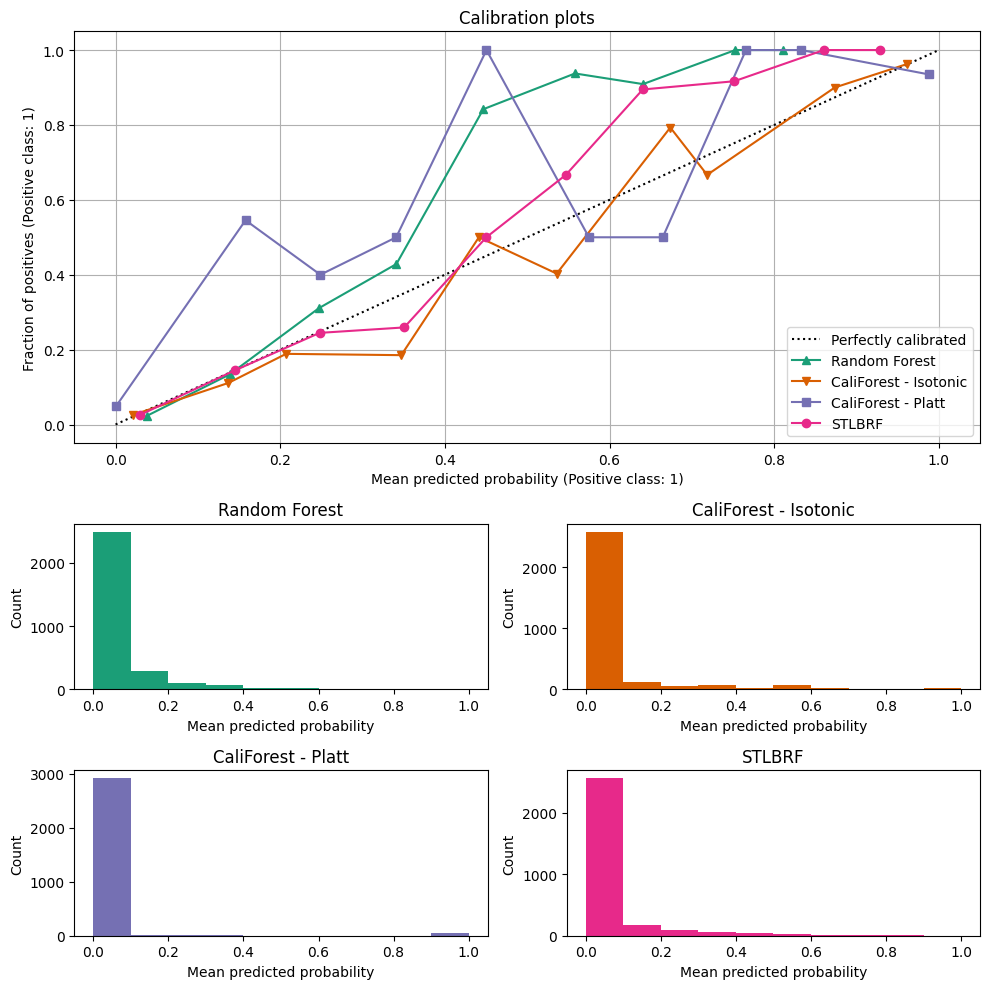

In [88]:

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

metrics_list = []
metrics_list2 = []

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:,1]
    l_loss = log_loss(y_test, y_prob)
    brier_loss = brier_score_loss(y_test, y_prob)
    calibration_error = cal.get_calibration_error(y_prob, y_test)
    
    score_auc = roc_auc_score(y_test, y_prob)
    score_hl = em.hosmer_lemeshow(y_test, y_prob)
    score_sh = em.spiegelhalter(y_test, y_prob)
    score_b, score_bs = em.scaled_brier_score(y_test, y_prob)
    rel_small, rel_large = em.reliability(y_test, y_prob)
    if name != "Random Forest - VennABERS":
        y_pred = clf.predict(X_test)
    else:
        y_pred = clf.predict(X_test, one_hot=False)
        
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
        
    metrics_list.append([name, acc, f1, brier_loss, l_loss, calibration_error])
    metrics_list2.append([name, score_auc, score_hl, score_sh, score_b, score_bs, rel_small, rel_large])
    display = CalibrationDisplay.from_predictions(
        y_test,
        y_prob,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

We compare accuracy, Brier loss, log loss and Expected Calibration Error (ECE, for more details of ECE computation see https://pypi.org/project/uncertainty-calibration/)

In [89]:
metrics_df = pd.DataFrame(metrics_list, columns = [
    'classifier', 'accuracy', 'f1', 'brier_loss', 'log_loss', 'ECE'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,accuracy,f1,brier_loss,log_loss,ECE
classifier,,,,,
Random Forest,0.942,0.282,0.046,0.172,0.039
CaliForest - Isotonic,0.944,0.510,0.044,0.162,0.043
CaliForest - Platt,0.946,0.383,0.051,0.578,0.078
STLBRF,0.947,0.428,0.044,0.169,0.009


In this example Venn-ABERS calibraiton achives a lower Brier and log loss, a lower ECE and the same degree of accuracy

In [90]:
metrics_df = pd.DataFrame(metrics_list2, columns = [
    'classifier', 'auc', 'hosmer_lemshow', 'speigelhalter', 'brier', 'brier_scaled', 'reliability_small', 'reliability_large'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,auc,hosmer_lemshow,speigelhalter,brier,brier_scaled,reliability_small,reliability_large
classifier,,,,,,,
Random Forest,0.881,0.000,0.001,0.046,0.284,0.001,0.000
CaliForest - Isotonic,0.885,0.366,0.672,0.044,0.316,0.000,0.000
CaliForest - Platt,0.882,0.000,0.000,0.051,0.195,0.006,0.002
STLBRF,0.876,0.001,0.087,0.044,0.306,0.000,0.000
